In [1]:
%matplotlib inline
import os, glob
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from weio import FASTOutputFile

In [2]:
prefix = 'NREL-1.7-103'
#outdir = 'outputs.serial/power_curve'
outdir = 'outputs/power_curve/rank_0'
D = 103.

In [3]:
design_pc = pd.read_csv(f'../{prefix}.csv').set_index('wind speed [m/s]')

In [4]:
def analyze_outputs_at_wspd(fpath,channels=['GenPwr_[kW]','GenTq_[kN-m]','RotSpeed_[rpm]','BldPitch1_[deg]']):
    df = FASTOutputFile(fpath).toDataFrame().set_index('Time_[s]')

    rotspd = df['RotSpeed_[rpm]'].values[-1]
    T = 60./rotspd # s/rev
    tmax = df.index[-1]
    dfmean = df.loc[slice(tmax-T,None),:].mean()
    
    Nchan = len(channels)
    fig,ax = plt.subplots(nrows=Nchan,sharex=True,figsize=(Nchan*3,12))
    for iax,channel in enumerate(channels):
        ax[iax].plot(df.index, df[channel])
        ax[iax].axhline(dfmean[channel], color='k', linestyle='--')
        ax[iax].set_ylabel(channel.replace('_',' '), fontsize='x-large')
        ax[iax].tick_params(labelsize='large')
    wspd = df['Wind1VelX_[m/s]']
    assert np.all(wspd == wspd[0])
    ax[0].set_title(f'$U_\\infty$ = {wspd[0]:g} m/s',fontsize='xx-large')
    ax[-1].set_xlabel('Time [s]', fontsize='x-large')
    ax[0].set_xlim(0,30)
    figpath = os.path.splitext(fpath)[0] + '_debug.png'
    fig.savefig(figpath)
    print('Wrote',figpath)
    plt.close()
    
    return dfmean,fig,ax

In [5]:
runs = glob.glob(os.path.join(outdir,'*.outb'))
runs.sort()

In [6]:
dflist = []
for outfile in runs:
    df,fig,ax = analyze_outputs_at_wspd(outfile)
    dflist.append(df)

Wrote outputs/power_curve/rank_0/NREL-1p7-103_0_powercurve_00_debug.png
Wrote outputs/power_curve/rank_0/NREL-1p7-103_0_powercurve_01_debug.png
Wrote outputs/power_curve/rank_0/NREL-1p7-103_0_powercurve_02_debug.png
Wrote outputs/power_curve/rank_0/NREL-1p7-103_0_powercurve_03_debug.png
Wrote outputs/power_curve/rank_0/NREL-1p7-103_0_powercurve_04_debug.png
Wrote outputs/power_curve/rank_0/NREL-1p7-103_0_powercurve_05_debug.png
Wrote outputs/power_curve/rank_0/NREL-1p7-103_0_powercurve_06_debug.png
Wrote outputs/power_curve/rank_0/NREL-1p7-103_0_powercurve_07_debug.png
Wrote outputs/power_curve/rank_0/NREL-1p7-103_0_powercurve_08_debug.png
Wrote outputs/power_curve/rank_0/NREL-1p7-103_0_powercurve_09_debug.png
Wrote outputs/power_curve/rank_0/NREL-1p7-103_0_powercurve_10_debug.png
Wrote outputs/power_curve/rank_0/NREL-1p7-103_0_powercurve_11_debug.png
Wrote outputs/power_curve/rank_0/NREL-1p7-103_0_powercurve_12_debug.png
Wrote outputs/power_curve/rank_0/NREL-1p7-103_0_powercurve_13_de

In [7]:
pc = pd.concat(dflist,axis=1).transpose().set_index('Wind1VelX_[m/s]')
pc = pc.rename(columns={
    'GenPwr_[kW]': 'generator power [kW]',
    'RtAeroFxh_[N]': 'rotor thrust [kN]',
    'RotTorq_[kN-m]': 'rotor torque [kN-m]',
    'RotSpeed_[rpm]': 'rotor speed [RPM]',
    'BldPitch1_[deg]': 'blade pitch [deg]',
    'RtAeroCp_[-]': 'Cp [-]',
    'RtAeroCt_[-]': 'Ct [-]',
})
pc['rotor thrust [kN]'] /= 1000.
pc['tip-speed ratio [-]'] = pc['rotor speed [RPM]'] * 2*np.pi / 60 * D/2 / pc.index

#pc.to_csv('../NREL-1.7-103_openfast.csv')

Text(0.5, 1.0, 'NREL-1.7-103')

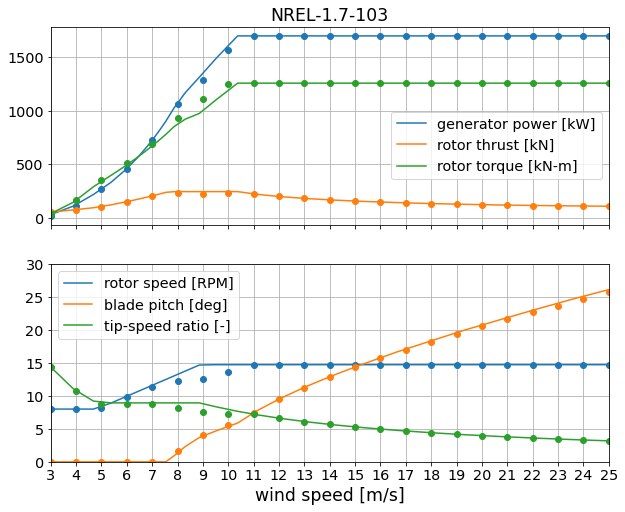

In [8]:
fig,ax = plt.subplots(nrows=2,sharex=True,figsize=(10,8))
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

for i, channel in enumerate(['generator power [kW]','rotor thrust [kN]','rotor torque [kN-m]']):
    ax[0].plot(design_pc.index, design_pc[channel], color=colors[i], label=channel)
    ax[0].plot(pc.index, pc[channel], 'o', color=colors[i])

for i, channel in enumerate(['rotor speed [RPM]','blade pitch [deg]','tip-speed ratio [-]']):
    ax[1].plot(design_pc.index, design_pc[channel], color=colors[i], label=channel)
    ax[1].plot(pc.index, pc[channel], 'o', color=colors[i])
ax[1].set_ylim((0,30))

for axi in ax:
    xticks = np.arange(3,26)
    axi.set_xticks(xticks)
    axi.set_xlim((xticks[0],xticks[-1]))
    axi.grid()
    axi.tick_params(labelsize='x-large')
    axi.legend(loc='best',fontsize='x-large')
axi.set_xlabel('wind speed [m/s]',fontsize='xx-large')
ax[0].legend(loc='center right',bbox_to_anchor=(1,0.4),fontsize='x-large') # need small adjustment in position
ax[0].set_title(prefix, fontsize='xx-large')

#fig.savefig(os.path.join(outdir,prefix+'_design_overview.png'),bbox_inches='tight')

## DEBUG

In [9]:
def read_pitch_saturation(fpath):
    with open(fpath,'r') as f:
        for _ in range(103):
            f.readline()
        Npitch = int(f.readline().split()[0])
        wspd = [float(val) for val in f.readline().split()[:Npitch]]
        pitchsat = [float(val)*180/np.pi for val in f.readline().split()[:Npitch]]
    return pd.Series(pitchsat,index=wspd)
ps = read_pitch_saturation('../OpenFAST/NREL-1p7-103_DISCON.IN')

Text(0.5, 1.0, 'NREL-1.7-103')

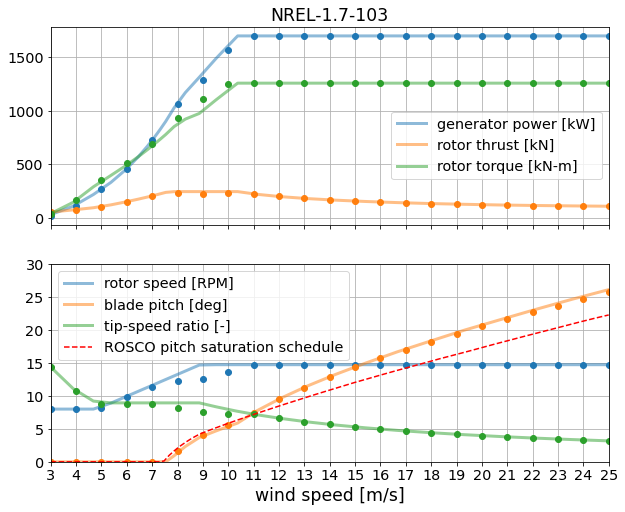

In [10]:
fig,ax = plt.subplots(nrows=2,sharex=True,figsize=(10,8))
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

for i, channel in enumerate(['generator power [kW]','rotor thrust [kN]','rotor torque [kN-m]']):
    ax[0].plot(design_pc.index, design_pc[channel], lw=3, alpha=0.5, color=colors[i], label=channel)
    ax[0].plot(pc.index, pc[channel], 'o', color=colors[i])

for i, channel in enumerate(['rotor speed [RPM]','blade pitch [deg]','tip-speed ratio [-]']):
    ax[1].plot(design_pc.index, design_pc[channel], lw=3, alpha=0.5, color=colors[i], label=channel)
    ax[1].plot(pc.index, pc[channel], 'o', color=colors[i])
ax[1].plot(ps.index, ps, 'r--', label='ROSCO pitch saturation schedule')
ax[1].set_ylim((0,30))

for axi in ax:
    xticks = np.arange(3,26)
    axi.set_xticks(xticks)
    axi.set_xlim((xticks[0],xticks[-1]))
    axi.grid()
    axi.tick_params(labelsize='x-large')
    axi.legend(loc='best',fontsize='x-large')
axi.set_xlabel('wind speed [m/s]',fontsize='xx-large')
ax[0].legend(loc='center right',bbox_to_anchor=(1,0.4),fontsize='x-large') # need small adjustment in position
ax[0].set_title(prefix, fontsize='xx-large')

FileNotFoundError: [Errno 2] File not found:: 'outputs/power_curve/NREL-1p7-103_powercurve_06.outb'

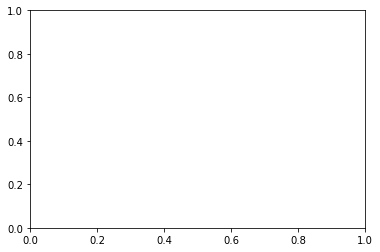

In [11]:
fig,ax = plt.subplots()
irun = 6
fout = FASTOutputFile(f'outputs/power_curve/NREL-1p7-103_powercurve_{irun:02d}.outb').toDataFrame().set_index('Time_[s]')
with open(f'outputs/power_curve/NREL-1p7-103_powercurve_{irun:02d}.RO.dbg','r') as f:
    f.readline()
    header = f.readline().split()
    units = f.readline().split()
    rout = pd.read_csv(f,names=header,delim_whitespace=True).set_index('Time')
ax.plot(fout.index, fout['Wind1VelX_[m/s]'], label='Wind1VelX')
ax.plot(rout.index, rout['WE_Vw'], label='ROSCO:WE_Vw')
ax.set_xlabel('Time [s]')
ax.legend()